# NLP on disaster tweets

#### About the competition:
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

##### Files:

* **train.csv** - the training set
* **test.csv** - the test set
* **sample_submission.csv** - a sample submission file in the correct format


##### Columns:

* **id** - a unique identifier for each tweet
* **text** - the text of the tweet
* **location** - the location the tweet was sent from (may be blank)
* **keyword** - a particular keyword from the tweet (may be blank)
* **target** - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("/home/jithendra/Downloads/NLP/nlp-getting-started/train.csv")
test = pd.read_csv("/home/jithendra/Downloads/NLP/nlp-getting-started/test.csv")
sample_submission = pd.read_csv("/home/jithendra/Downloads/NLP/nlp-getting-started/sample_submission.csv")

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
# seeing if there are any duplicated rows
train.duplicated().sum()

0

#### Tweets distirbution

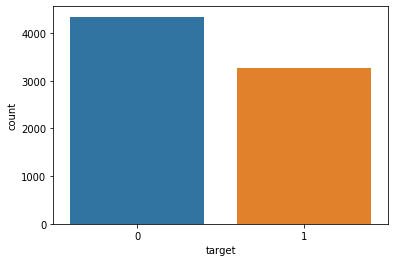

In [6]:
sns.countplot(train.target)

* The dataset is not so imbalanced

In [7]:
train.shape

(7613, 5)

In [8]:
test.shape

(3263, 4)

In [9]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

* Only a very few tweets are missing keyword

#### What is length of a tweet in general in both cases?

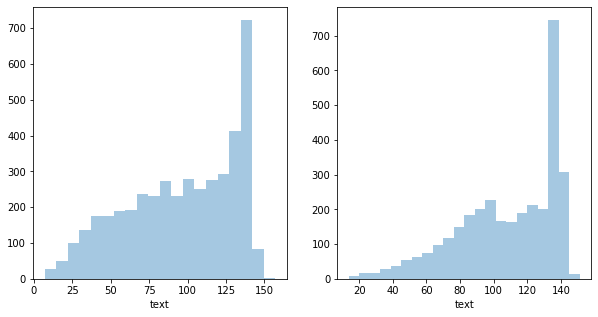

In [11]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
sns.distplot(train[train['target']==0]['text'].str.len(), ax=axes[0], kde=False)
sns.distplot(train[train['target']==1]['text'].str.len(), ax=axes[1], kde=False)

* Both have nearly same length, the dataset contains all lengthy tweets

#### How keywords are related to the tweets?

In [12]:
# Checking number of unique keywords
train.keyword.nunique()

221

In [13]:
test.keyword.nunique()

221

* Both have same number of unique keywords

In [15]:
# whether the unique keywords are same or not
set(train.keyword.unique()) - set(test.keyword.unique())

set()

* Train and Test have same set of keywords

In [17]:
# 10 most common keywords in disaster tweets
dk = train[train['target']==1].keyword.value_counts().head(10)
dk

derailment           39
wreckage             39
outbreak             39
typhoon              37
debris               37
oil%20spill          37
rescuers             32
suicide%20bombing    32
evacuated            32
suicide%20bomb       32
Name: keyword, dtype: int64

In [18]:
# 10 most common keywords in normal tweets
ndk = train[train.target==0].keyword.value_counts().head(10)
ndk

body%20bags    40
harm           37
armageddon     37
wrecked        36
deluge         36
ruin           36
fear           35
twister        35
explode        35
siren          35
Name: keyword, dtype: int64

Text(0.5, 1.0, 'non-disaster tweets')

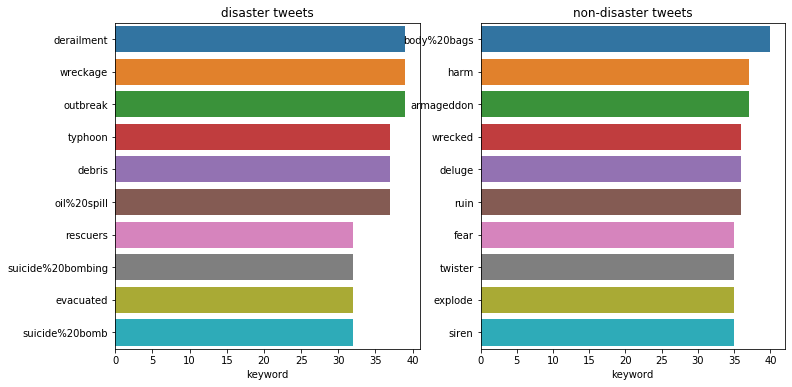

In [19]:
# plotting them
fig, axes = plt.subplots(1,2,figsize=(12,6))
sns.barplot(dk, dk.index, ax=axes[0]).set_title('disaster tweets')        
sns.barplot(ndk, ndk.index, ax=axes[1]).set_title('non-disaster tweets')

### Tweet preprocessing and cleaning
reference: https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/

In [20]:
import re
import string
import nltk

In [21]:
# combining train and test sets for better preprocessing
combi = train.append(test, ignore_index=True, sort=True)

In [22]:
def remove_pattern(input_text, pattern):
    r = re.findall(pattern, input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
    return input_text

In [23]:
# removing twitter handles (@user)
combi['text1'] = np.vectorize(remove_pattern)(combi['text'], "@[\w]*")

In [24]:
# removing punctuations, numbers and special characters
combi['text1'] = combi['text1'].str.replace("[^a-zA-Z#]", " ")

In [25]:
# removing shortwords
combi['text1'] = combi['text1'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [26]:
combi.head()

,id,keyword,location,target,text,text1
0,1,NaN,NaN,1.0,Our Deeds are the Reason of this #earthquake M...,Deeds Reason this #earthquake ALLAH Forgive
1,4,NaN,NaN,1.0,Forest fire near La Ronge Sask. Canada,Forest fire near Ronge Sask Canada
2,5,NaN,NaN,1.0,All residents asked to 'shelter in place' are ...,residents asked shelter place being notified o...
3,6,NaN,NaN,1.0,"13,000 people receive #wildfires evacuation or...",people receive #wildfires evacuation orders Ca...
4,7,NaN,NaN,1.0,Just got sent this photo from Ruby #Alaska as ...,Just sent this photo from Ruby #Alaska smoke f...


In [27]:
# Tokenization
token_tweet = combi['text1'].apply(lambda x: x.split())
token_tweet.head()

0    [Deeds, Reason, this, #earthquake, ALLAH, Forg...
1            [Forest, fire, near, Ronge, Sask, Canada]
2    [residents, asked, shelter, place, being, noti...
3    [people, receive, #wildfires, evacuation, orde...
4    [Just, sent, this, photo, from, Ruby, #Alaska,...
Name: text1, dtype: object

* Tokens are individual terms or words, and **tokenization** is the process of splitting a string of text into tokens.

In [28]:
# Stemming
from nltk.stem.porter import *
stemmer = PorterStemmer()
token_tweet = token_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
token_tweet.head()

0       [deed, reason, thi, #earthquak, allah, forgiv]
1             [forest, fire, near, rong, sask, canada]
2    [resid, ask, shelter, place, be, notifi, offic...
3    [peopl, receiv, #wildfir, evacu, order, califo...
4    [just, sent, thi, photo, from, rubi, #alaska, ...
Name: text1, dtype: object

* **Stemming** is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word. 
* For example – “play”, “player”, “played”, “plays” and “playing” are the different variations of the word – “play”. 

In [29]:
# stitching these tokens back together. 
for i in range(len(token_tweet)):
    token_tweet[i] = ' '.join(token_tweet[i])

combi['text2'] = token_tweet

In [30]:
combi.head()

,id,keyword,location,target,text,text1,text2
0,1,NaN,NaN,1.0,Our Deeds are the Reason of this #earthquake M...,Deeds Reason this #earthquake ALLAH Forgive,deed reason thi #earthquak allah forgiv
1,4,NaN,NaN,1.0,Forest fire near La Ronge Sask. Canada,Forest fire near Ronge Sask Canada,forest fire near rong sask canada
2,5,NaN,NaN,1.0,All residents asked to 'shelter in place' are ...,residents asked shelter place being notified o...,resid ask shelter place be notifi offic other ...
3,6,NaN,NaN,1.0,"13,000 people receive #wildfires evacuation or...",people receive #wildfires evacuation orders Ca...,peopl receiv #wildfir evacu order california
4,7,NaN,NaN,1.0,Just got sent this photo from Ruby #Alaska as ...,Just sent this photo from Ruby #Alaska smoke f...,just sent thi photo from rubi #alaska smoke fr...


#### WordCloud
* A **wordcloud** is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

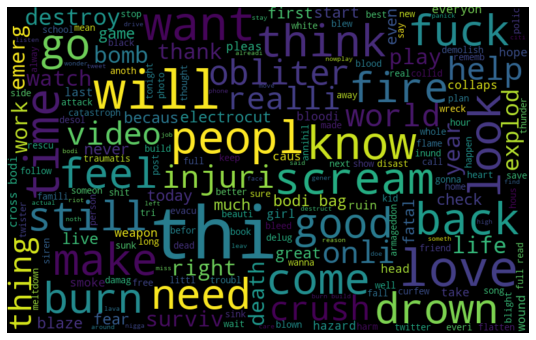

In [32]:
# wordcloud of normal tweets
all_words_notdis = ' '.join([text for text in combi['text2'][combi['target']==0]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_notdis)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

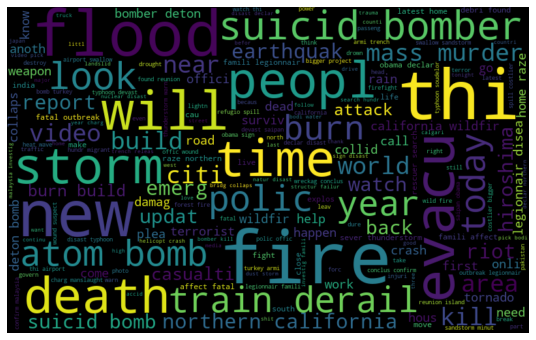

In [34]:
# wordcloud of disaster tweets
all_words_dis = ' '.join([text for text in combi['text2'][combi['target']==1]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_dis)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Impact of hashtags on tweets
reference: https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/

In [35]:
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [36]:
HT_notdis = hashtag_extract(combi['text2'][combi['target'] == 0])

HT_dis = hashtag_extract(combi['text2'][combi['target'] == 1])

# unnesting list
HT_notdis = sum(HT_notdis,[])
HT_dis = sum(HT_dis,[])

Text(0.5, 1.0, 'disaster tweets')

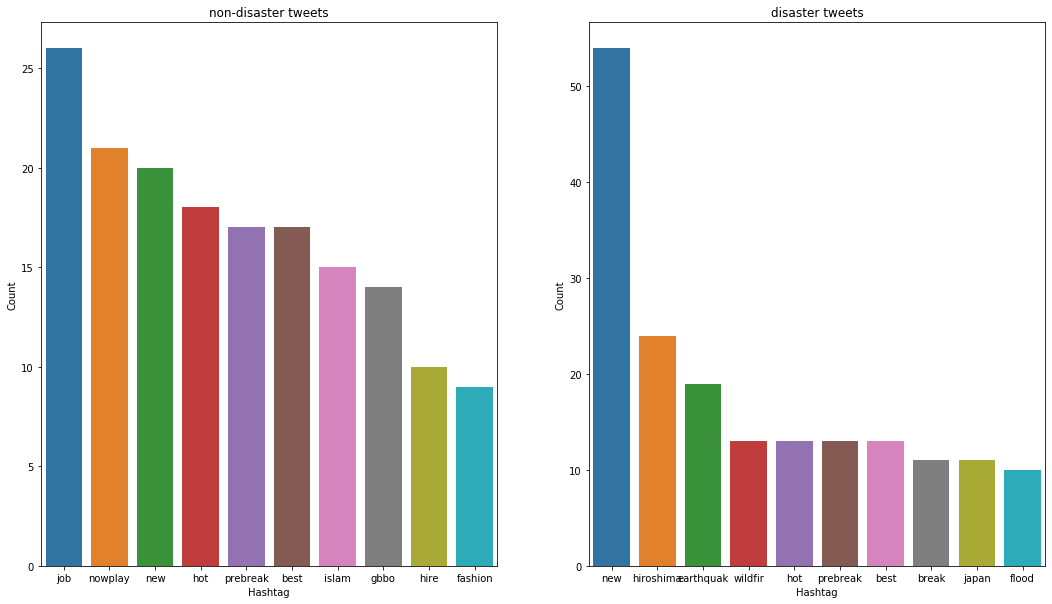

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

In [37]:
fig, axes = plt.subplots(1,2,figsize=(18,10))
#not disaster tweets
a = nltk.FreqDist(HT_notdis)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
d = d.nlargest(columns="Count", n=10)
plt.figure(figsize=(16,5))
sns.barplot(data=d, x= "Hashtag", y = "Count",ax=axes[0]).set_title('non-disaster tweets')

a = nltk.FreqDist(HT_dis)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
d = d.nlargest(columns="Count", n=10)
plt.figure(figsize=(16,5))
sns.barplot(data=d, x= "Hashtag", y = "Count",ax=axes[1]).set_title('disaster tweets')

### Preparing text data for Machine Learning
reference: https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(max_df=0.90, min_df=2, max_features=300, stop_words='english')
tfidf = tfidf_vec.fit_transform(combi['text'])

In [39]:
tfidf.shape

(10876, 300)

In [42]:
print(train.shape)
print(test.shape)
print(combi.shape) # 7613+3263 = 10876

(7613, 5)
(3263, 4)
(10876, 7)


In [44]:
# splitting final test and final train sets
train_f = tfidf[:7613]
test_f = tfidf[7613:]

In [45]:
# 80% for training and 20% for validation
x_train = train_f[:6090]
x_valid = train_f[6090:]
y_train = combi[:6090]['target']
y_valid = combi[6090:7613]['target']

### Building Model

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,f1_score, confusion_matrix
lr = LogisticRegression(solver='liblinear')
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
print ('Training f-1 score: %.4f' % f1_score(y_train, lr.predict(x_train)))

Training f-1 score: 0.7087


In [49]:
# predicting on the validation set
valid_prediction = lr.predict(x_valid)
valid_prediction = valid_prediction.astype(np.int)

In [50]:
print ('f-1 score: %.4f' % f1_score(y_valid, valid_prediction))

f-1 score: 0.6902


In [51]:
# predicting on the finalTest set
prediction = lr.predict(test_f)
prediction = prediction.astype(np.int)

In [52]:
submit = sample_submission.copy()
submit.target = prediction
submit.to_csv('lr_sub.csv', index=False)

In [53]:
submit.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
